In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create DataFrame
Clean data using IQR

In [2]:
df = pd.read_csv("housePrice.csv")

df["Area"] = pd.to_numeric(df["Area"], errors='coerce')

df = df.dropna()

# Throw up outlier data
# "Area" column
area_column = np.sort(np.array(df["Area"]))
area_median = np.median(area_column)
area_q1, area_q3 = np.median(np.split(area_column, 2)[0]), np.median(np.split(area_column, 2)[1])
area_IQR = area_q3 - area_q1
area_upper, area_lower = area_q3 + (1.5 * area_IQR), area_q1 - (1.5 * area_IQR)
df = df[df["Area"] <= area_upper]
df = df[df["Area"] >= area_lower]

# "Price" column
price_column = np.sort(np.array(df["Price"]))
price_median = np.median(price_column)
price_q1, price_q3 = np.median(np.split(price_column, 2)[0]), np.median(np.split(price_column, 2)[1])
price_IQR = price_q3 - price_q1
price_upper, price_lower = price_q3 + (1.5 * price_IQR), price_q1 - (1.5 * price_IQR)
df = df[df["Price"] <= price_upper]
df = df[df["Price"] >= price_lower]

# Make numeric value (Address)
Give a score to every address using the mean of price

In [3]:
address_set = set(df["Address"])
address_ranking = {}
for address in address_set:
    address_ranking[address] = np.mean(df[df["Address"] == address].Price)

addresses = list(df["Address"])

for i in range(len(addresses)):
    for key in address_ranking:
        if key in addresses[i]:
            addresses[i] = address_ranking[key]
            break

df = df.assign(Address=addresses)

# Make numeric and preprocessing data
Give binary value to True/False data and split train/test for model

In [4]:
df = df.dropna()

numeric_columns = ["Area", "Room", "Parking", "Warehouse", "Elevator", "Address", "Price"]

msk = np.random.rand(len(df)) < 0.7

cdf = df[numeric_columns]

cdf["Parking"] = cdf["Parking"].astype(int)
cdf["Warehouse"] = cdf["Warehouse"].astype(int)
cdf["Elevator"] = cdf["Elevator"].astype(int)

scaler = MinMaxScaler()

# Fit and transform the numeric columns
cdf[numeric_columns] = scaler.fit_transform(cdf[numeric_columns])

train = cdf[msk]
test = cdf[~msk]

x_train = np.asanyarray(train[["Area", "Room", "Parking", "Warehouse", "Elevator", "Address"]])
x_test = np.asanyarray(test[["Area", "Room", "Parking", "Warehouse", "Elevator", "Address"]])

y_train = np.asanyarray(train[["Price"]])
y_test = np.asanyarray(test[["Price"]])

C:\Users\pc\AppData\Local\Temp\ipykernel_17560\2460990107.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["Parking"] = cdf["Parking"].astype(int)
C:\Users\pc\AppData\Local\Temp\ipykernel_17560\2460990107.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["Warehouse"] = cdf["Warehouse"].astype(int)
C:\Users\pc\AppData\Local\Temp\ipykernel_17560\2460990107.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

The unnormalized value for plot

In [5]:
test_area = np.array([])
test_price = np.array([])

for i in range(len(x_test)):
    test_area = np.append(test_area, x_test[i][0])
    test_price = np.append(test_price, y_test[i][0])

min_area = df["Area"].min()
max_area = df["Area"].max()

min_price = df["Price"].min()
max_price = df["Price"].max()

unnormalized_area = test_area * (max_area - min_area) + min_area
unnormalized_price = test_price * (max_price - min_price) + min_price

# Create model
Preparing the model(Polynomial-Model), fit and transform the data for using in polynomial model
finally fit data

In [10]:
poly_features = PolynomialFeatures(degree=2)
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.fit_transform(x_test)

model = LinearRegression()
model.fit(x_train_poly, y_train)
x_train

array([[0.20625   , 0.2       , 1.        , 1.        , 1.        ,
        0.29994012],
       [0.1875    , 0.2       , 1.        , 1.        , 1.        ,
        0.29994012],
       [0.30625   , 0.4       , 1.        , 1.        , 1.        ,
        0.05786887],
       ...,
       [0.275     , 0.4       , 1.        , 1.        , 1.        ,
        0.53269927],
       [0.41875   , 0.4       , 1.        , 1.        , 1.        ,
        0.29994012],
       [0.28125   , 0.4       , 0.        , 0.        , 0.        ,
        0.02999567]])

Predict test data and create a scatter plot

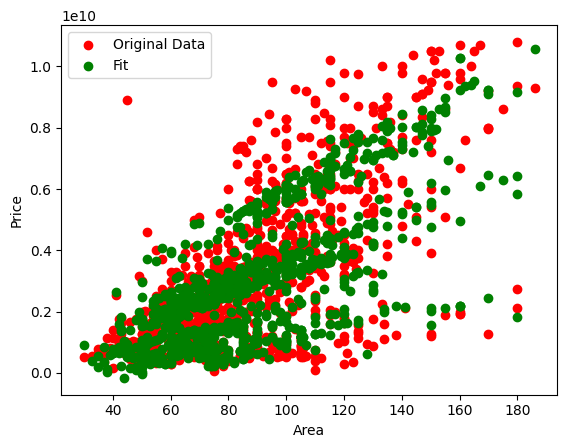

In [7]:
predicted = model.predict(x_test_poly)

plt.scatter(unnormalized_area, unnormalized_price , label="Original Data", color="red")
plt.scatter(unnormalized_area, predicted * 10000000000, label="Fit", color="green")
plt.xlabel("Area")
plt.ylabel("Price")
plt.legend()
plt.show()

# Model performance
Mean_Absolute_Error / Mean_Squared_Error / R2_Score

In [8]:
from sklearn.metrics import r2_score

MAE = np.mean(np.absolute(predicted - y_test))
MSE = np.mean((predicted - y_test) ** 2)
R2 = r2_score(y_test, predicted)

print(f"Mean_Absolute_Error: {MAE}")
print(f"Mean_Squared_Error: {MSE}")
print(f"R2_Score: {R2}")

Mean_Absolute_Error: 0.05600849067314405
Mean_Squared_Error: 0.007448442869078125
R2_Score: 0.8617481976144705


Get input from the user for predict the sample price 

In [9]:
'''while True:
    try:
        area = int(input("Area: "))
        break
    except:
        print("Invalid input!")

while True:
    try:
        room = int(input("Room: "))
        break
    except:
        print("Invalid input!")

while True:
    try:
        parking = int(input("Parking(yes(1), no(0)): "))
        if parking == 1 or parking == 0:
            break
    except:
        print("Invalid input!")

while True:
    try:
        warehouse = int(input("Warehouse(yes(1), no(0)): "))
        if warehouse == 1 or warehouse == 0:
            break
    except:
        print("Invalid input!")

while True:
    try:
        elevator = int(input("Elevator(yes(1), no(0)): "))
        if elevator == 1 or elevator == 0:
            break
    except:
        print("Invalid input!")

while True:
    try:
        address = input("Address: ").capitalize()
        break
    except:
        print("Invalid input!")

features = [area, room, parking, warehouse, elevator, address]

address = address_ranking.get(address, np.mean(df.Price))

area = (area - min_area) / (max_area - min_area)
room *= 0.2
address = (address - min_price) / (max_price - min_price)

user_input = [[area, room, parking, warehouse, elevator, address]]
user_input_poly = poly_features.fit_transform(user_input)

result = model.predict(user_input_poly) * (max_price - min_price) + min_price
result = int(result[0][0])

print(f"Area: {features[0]} / Room: {features[1]} / Parking: {features[2]} / Warehouse: {features[3]} / Elevator: {features[4]} / Address: {features[5]}")
print(f"Predicted price: {result}")'''

Area: 222 / Room: 1 / Parking: 1 / Warehouse: 1 / Elevator: 1 / Address: Niavaran
Predicted price: 12939559332
